In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
import os
import statsmodels.api as sm
#from graphviz import Source
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
#from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
file_path = 'C:\\Users\\gagno\\OneDrive\\Documents\\Capstone\\GenericWellData.xlsx'
data = pd.read_excel(file_path)

In [3]:
# Basic Data Overview
print("Basic Data Overview:")
print(f"Dataset dimensions: {data.shape}")
print("\nData types:")
print(data.dtypes.value_counts())


Basic Data Overview:
Dataset dimensions: (16707, 87)

Data types:
float64           59
int64             23
datetime64[ns]     3
object             2
dtype: int64


In [4]:
# Identifying missing values
missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
print("\nColumns with missing values and their count:")
print(missing_values)


Columns with missing values and their count:
AvgStageSpacing_FT                         15970
FractureStages                             15969
First36MonthProd_MCFEPer1000FT              5847
First36MonthWaterProductionBBLPer1000Ft     5847
First36MonthGas_MCFPer1000FT                5847
                                           ...  
First3MonthOil_BBLPer1000FT                    1
First3MonthProd_MCFEPer1000FT                  1
First3MonthGas_MCFPer1000FT                    1
First3MonthProd_BOEPer1000FT                   1
CumOil_BBLPer1000FT                            1
Length: 61, dtype: int64


In [5]:
# Summary Statistics for continuous variables
print("\nSummary Statistics for continuous variables:")
print(data.describe().transpose())



Summary Statistics for continuous variables:
                         count          mean           std     min  \
Well Index             16707.0  8.354000e+03  4.823040e+03     1.0   
TrueVerticalDepth_FT   16705.0  8.656169e+03  9.119473e+02   556.0   
MeasuredDepth_FT       16660.0  1.839773e+04  2.397761e+03  5253.0   
InitialProductionYear  16707.0  2.018804e+03  2.726209e+00  2011.0   
UpperPerforation_FT    16573.0  8.964134e+03  9.627945e+02   169.0   
...                        ...           ...           ...     ...   
CumProd_MCFE           16707.0  2.150990e+06  1.122085e+06   272.0   
CumProd_MCFEPer1000FT  16706.0  2.412449e+05  1.448326e+05    58.0   
CumOil_BBL             16707.0  2.426871e+05  1.312000e+05     0.0   
CumOil_BBLPer1000FT    16706.0  2.699403e+04  1.506463e+04     0.0   
CumWater_BBL           16707.0  5.187399e+05  4.551531e+05     0.0   

                              25%        50%         75%         max  
Well Index                4177.50     8354

In [6]:
# Temporal Analysis - Simplified overview for initial and completion dates
print("\nTemporal Analysis - Year distribution for DrillingStartDate and InitialProductionDate:")
print(data[['DrillingStartDate', 'InitialProductionDate']].apply(lambda x: x.dt.year).describe())


Temporal Analysis - Year distribution for DrillingStartDate and InitialProductionDate:
       DrillingStartDate  InitialProductionDate
count       16706.000000           16707.000000
mean         2018.199569            2018.804214
std             2.722160               2.726209
min          1952.000000            2011.000000
25%          2016.000000            2017.000000
50%          2018.000000            2019.000000
75%          2020.000000            2021.000000
max          2023.000000            2023.000000


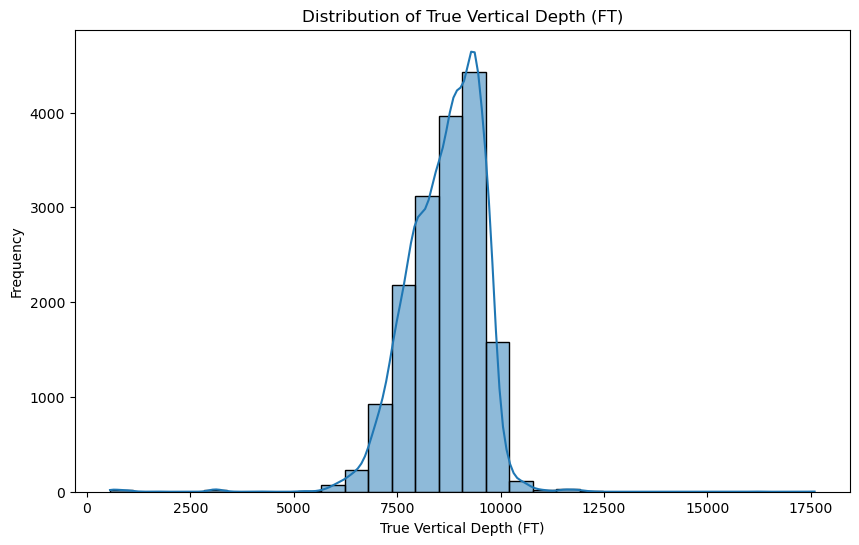

In [7]:
# Histogram for TrueVerticalDepth_FT
plt.figure(figsize=(10, 6))
sns.histplot(data['TrueVerticalDepth_FT'], bins=30, kde=True)
plt.title('Distribution of True Vertical Depth (FT)')
plt.xlabel('True Vertical Depth (FT)')
plt.ylabel('Frequency')
plt.show()

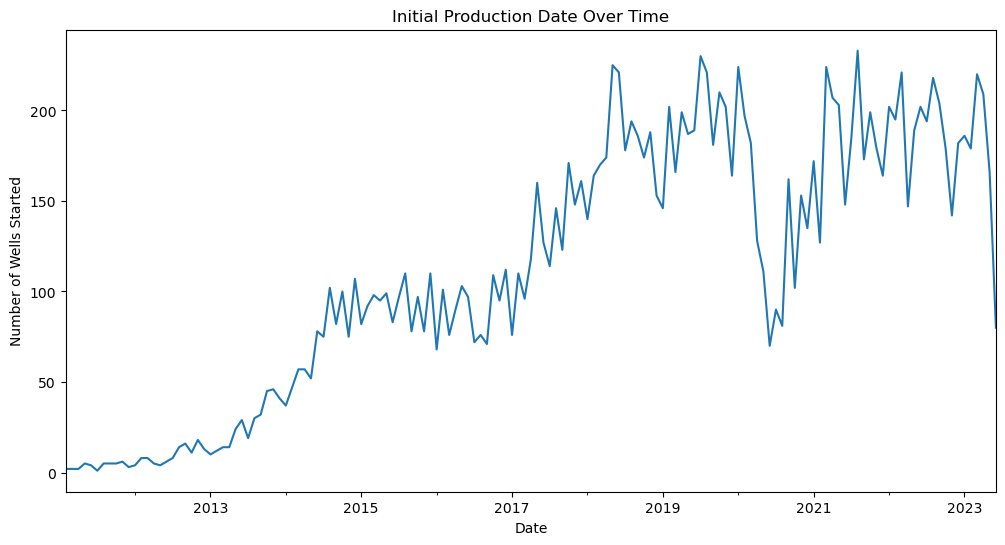

In [8]:
# Time Series plot for Initial Production Date
plt.figure(figsize=(12, 6))
data['InitialProductionDate'].value_counts().sort_index().plot(kind='line')
plt.title('Initial Production Date Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Wells Started')
plt.show()

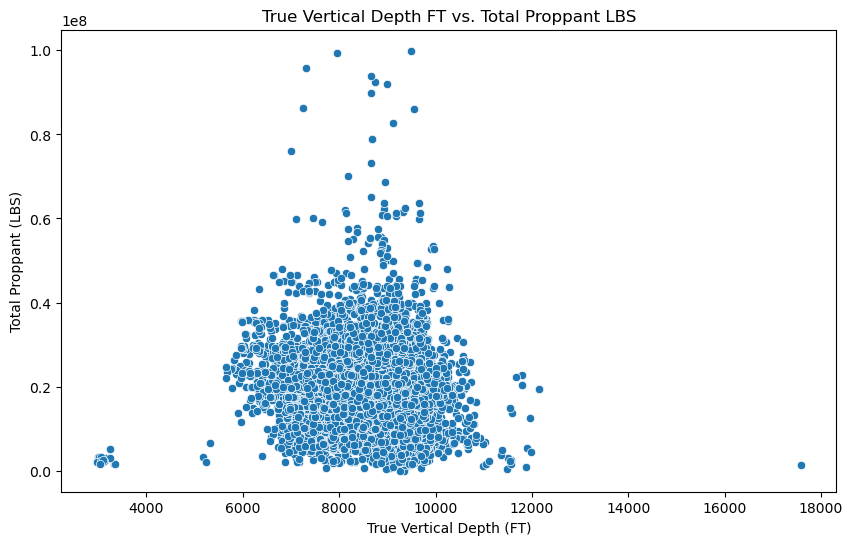

In [9]:
# Scatter plot for TrueVerticalDepth_FT vs. TotalProppant_LBS
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TrueVerticalDepth_FT', y='TotalProppant_LBS', data=data)
plt.title('True Vertical Depth FT vs. Total Proppant LBS')
plt.xlabel('True Vertical Depth (FT)')
plt.ylabel('Total Proppant (LBS)')
plt.show()

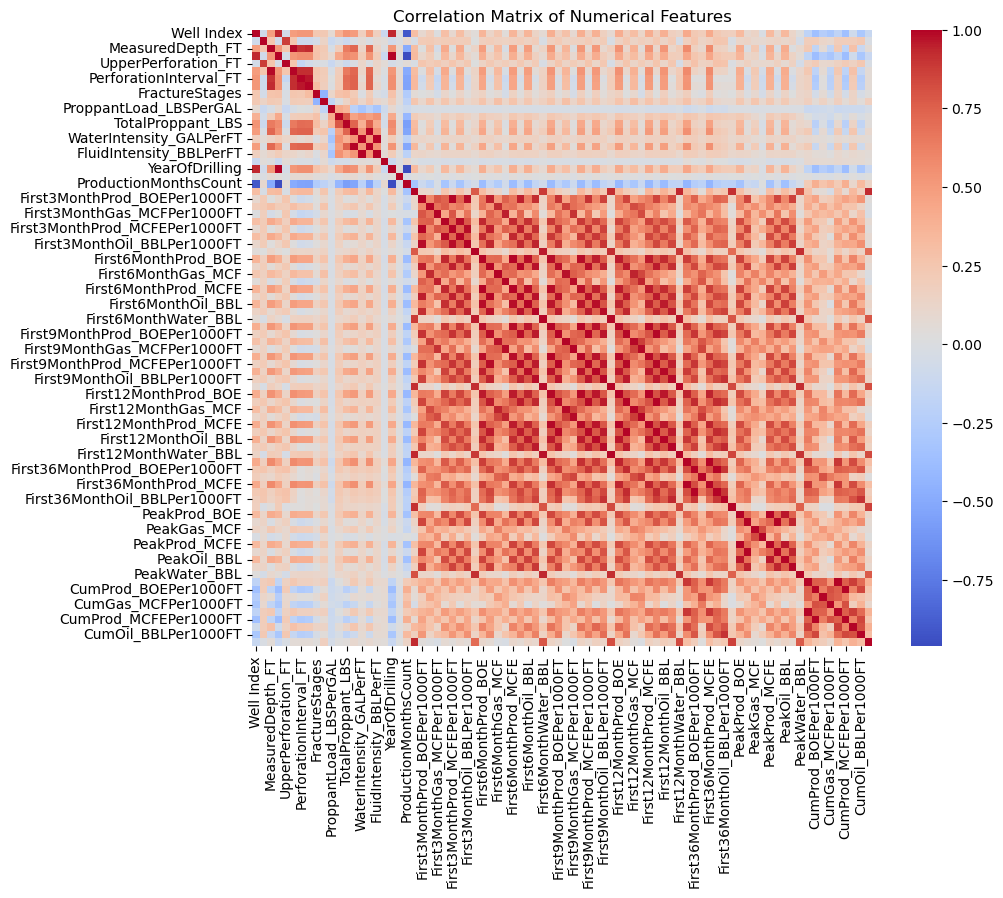

In [10]:
# Correlation Analysis
plt.figure(figsize=(10, 8))
corr = data.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt=".1f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [11]:
#Fill missing values with median for numerical columns and mode for categorical columns
for column in data.columns:
    if data[column].dtype == 'float64' or data[column].dtype == 'int64':
        data[column].fillna(data[column].median(), inplace=True)
    elif data[column].dtype == 'object':
        data[column].fillna(data[column].mode()[0], inplace=True)


In [12]:
# Identify numerical columns
numerical_cols = data.select_dtypes(include=[np.number]).columns

# Loop through each numerical column to remove outliers
for col in numerical_cols:
    data = data[(np.abs(stats.zscore(data[col])) < 3)]

In [13]:
data = data.drop_duplicates()

In [14]:
#Remove Date fields from training data set
#Keep 'InitialProductionYear' column?
#Reponse variable limited to only first 3 months production output oil - Change as needed for each response variable
y = data['First3MonthOil_BBLPer1000FT']
x = data.drop(['Well Index', 'InitialProductionDate', 'DrillingStartDate','InitialProductionYear', 'DrillingCompletionDate', 'YearOfDrilling', 'InitialProductionMonth','First36MonthWater_BBL', 'First3MonthGas_MCF', 'First3MonthGas_MCFPer1000FT', 'First3MonthProd_MCFE', 'First3MonthProd_MCFEPer1000FT', 'First3MonthOil_BBL', 'First3MonthOil_BBLPer1000FT', 'First3MonthWater_BBL', 'First6MonthProd_BOE', 'First6MonthProd_BOEPer1000FT', 'First6MonthGas_MCF', 'First6MonthGas_MCFPer1000FT', 'First6MonthProd_MCFE', 'First6MonthProd_MCFEPer1000FT', 'First6MonthOil_BBL', 'First6MonthOil_BBLPer1000FT', 'First6MonthWater_BBL', 'First9MonthProd_BOE', 'First9MonthProd_BOEPer1000FT', 'First9MonthGas_MCF', 'First9MonthGas_MCFPer1000FT', 'First9MonthProd_MCFE', 'First9MonthProd_MCFEPer1000FT', 'First9MonthOil_BBL', 'First9MonthOil_BBLPer1000FT', 'First9MonthWater_BBL', 'First12MonthProd_BOE', 'First12MonthProd_BOEPer1000FT', 'First12MonthGas_MCF', 'First12MonthGas_MCFPer1000FT', 'First12MonthProd_MCFE', 'First12MonthProd_MCFEPer1000FT', 'First12MonthOil_BBL', 'First12MonthOil_BBLPer1000FT', 'First12MonthWater_BBL', 'First36MonthProd_BOE', 'First36MonthProd_BOEPer1000FT', 'First36MonthGas_MCFPer1000FT', 'First36MonthProd_MCFE', 'First36MonthProd_MCFEPer1000FT', 'First36MonthOil_BBLPer1000FT', 'First36MonthWaterProductionBBLPer1000Ft', 'PeakProd_BOE', 'PeakProd_BOEPer1000FT', 'PeakGas_MCF', 'PeakGas_MCFPer1000FT', 'PeakProd_MCFE', 'PeakProd_MCFEPer1000FT', 'PeakOil_BBL', 'PeakOil_BBLPer1000FT', 'PeakWater_BBL', 'CumProd_BOE', 'CumProd_BOEPer1000FT', 'CumGas_MCF', 'CumGas_MCFPer1000FT', 'CumProd_MCFE', 'CumProd_MCFEPer1000FT', 'CumOil_BBL', 'CumOil_BBLPer1000FT', 'CumWater_BBL', 'First3MonthProd_BOEPer1000FT'], axis = 1)

In [15]:
#Convert Dummy Category Columns form True False to binary
x = pd.get_dummies(x, columns=['OilTest_Method'])
for col in x.columns:
    if x[col].dtype == 'bool':
        x[col] = x[col].astype(int)

In [16]:
#Convert float data type to numeric and remove comma separators of numbers
for col in x.columns:
    if x[col].dtype == 'float':
        x[col] = x[col].astype(int)
        
for col in x.columns:
    if x[col].dtype == 'object':  # Check if the column contains string values
        # Remove commas and convert to numeric, setting errors to 'coerce' to handle non-numeric strings
        x[col] = pd.to_numeric(x[col].str.replace(',', ''), errors='coerce')

In [18]:
#Train Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=99)

In [19]:
#random forest classifier model
rfc_mod = RandomForestRegressor(n_estimators=1000, random_state=99) 
rfc_mod.fit(x_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=99)

In [22]:
feature_importance = rfc_mod.feature_importances_
print(feature_importance)

[0.14647912 0.03941858 0.07099873 0.0392676  0.05951463 0.0686138
 0.00100957 0.00122176 0.00430859 0.08523353 0.06160003 0.03269294
 0.0620597  0.03376826 0.01821495 0.07089148 0.05518772 0.13051683
 0.00283043 0.00785499 0.00831676]


In [23]:
feature_importance

array([0.14647912, 0.03941858, 0.07099873, 0.0392676 , 0.05951463,
       0.0686138 , 0.00100957, 0.00122176, 0.00430859, 0.08523353,
       0.06160003, 0.03269294, 0.0620597 , 0.03376826, 0.01821495,
       0.07089148, 0.05518772, 0.13051683, 0.00283043, 0.00785499,
       0.00831676])

In [24]:
feature_names = list(x_train.columns)

sorted_idx = feature_importance.argsort()[::-1]
sorted_feature_importance = feature_importance[sorted_idx][::-1]
sorted_feature_names = [feature_names[i] for i in sorted_idx][::-1]
print(sorted_idx)
print(sorted_feature_importance)
print(sorted_feature_names)

[ 0 17  9  2 15  5 12 10  4 16  1  3 13 11 14 20 19  8 18  7  6]
[0.00100957 0.00122176 0.00283043 0.00430859 0.00785499 0.00831676
 0.01821495 0.03269294 0.03376826 0.0392676  0.03941858 0.05518772
 0.05951463 0.06160003 0.0620597  0.0686138  0.07089148 0.07099873
 0.08523353 0.13051683 0.14647912]
['FractureStages', 'AvgStageSpacing_FT', 'OilTest_Method_FLOWING', 'ProppantLoad_LBSPerGAL', 'OilTest_Method_GAS LIFT', 'OilTest_Method_PUMPING', 'FluidIntensity_BBLPerFT', 'TotalWaterPumped_GAL', 'TotalFluidPumped_BBL', 'LowerPerforation_FT', 'MeasuredDepth_FT', 'DrillingDuration_DAYS', 'PerforationInterval_FT', 'TotalProppant_LBS', 'WaterIntensity_GALPerFT', 'LateralLength_FT', 'AcidVolume_BBL', 'UpperPerforation_FT', 'ProppantIntensity_LBSPerFT', 'ProductionMonthsCount', 'TrueVerticalDepth_FT']


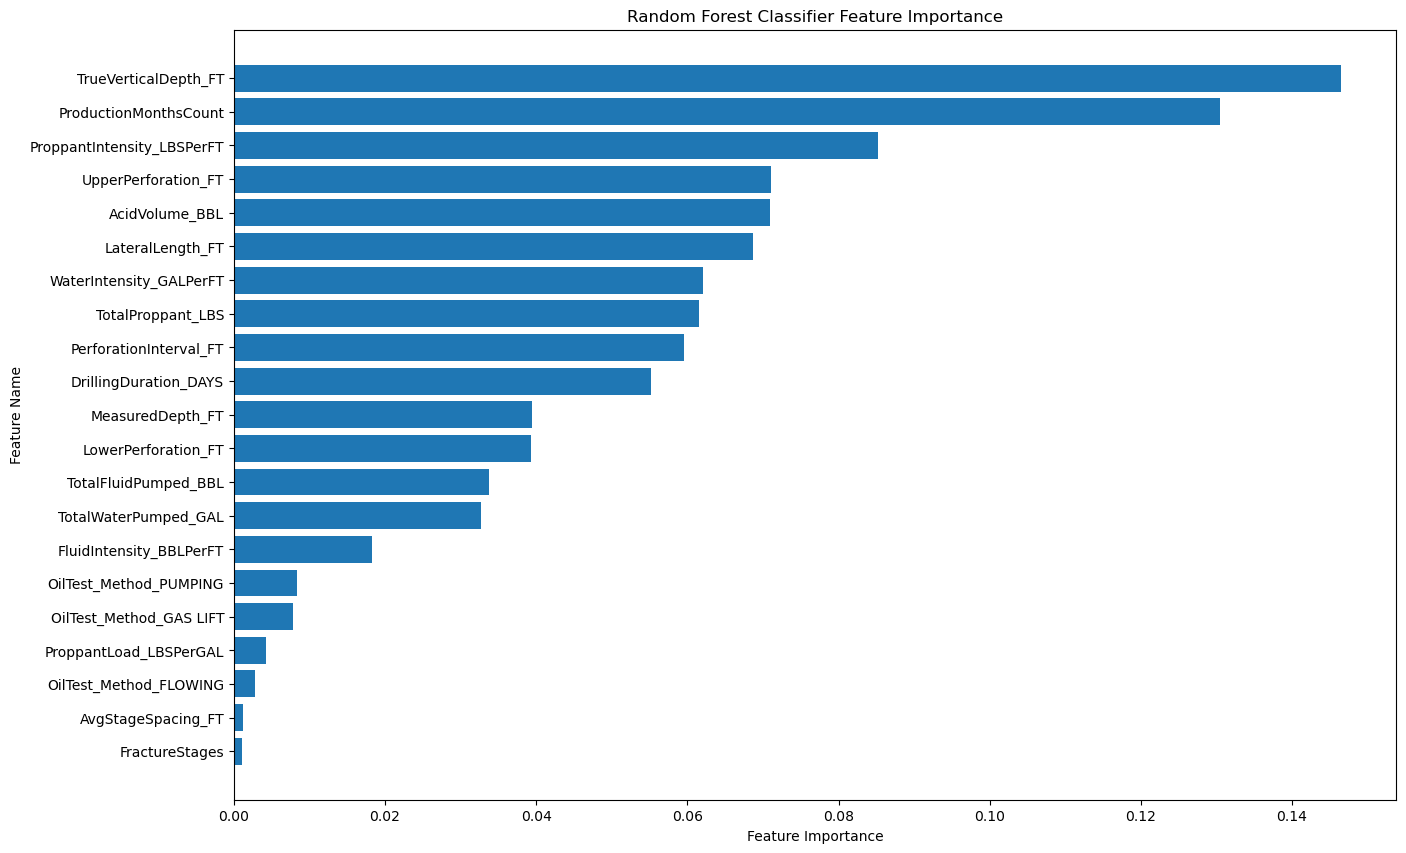

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.barh(range(x_train.shape[1]), sorted_feature_importance, align='center')
plt.yticks(range(x_train.shape[1]), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Random Forest Classifier Feature Importance')
plt.show()

In [26]:
y_pred = rfc_mod.predict(x_test)


In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


Mean Absolute Error (MAE): 1460.2692254901963
Mean Squared Error (MSE): 3513098.8424550747
Root Mean Squared Error (RMSE): 1874.3262369329077
R-squared (R²): 0.3085675835746049


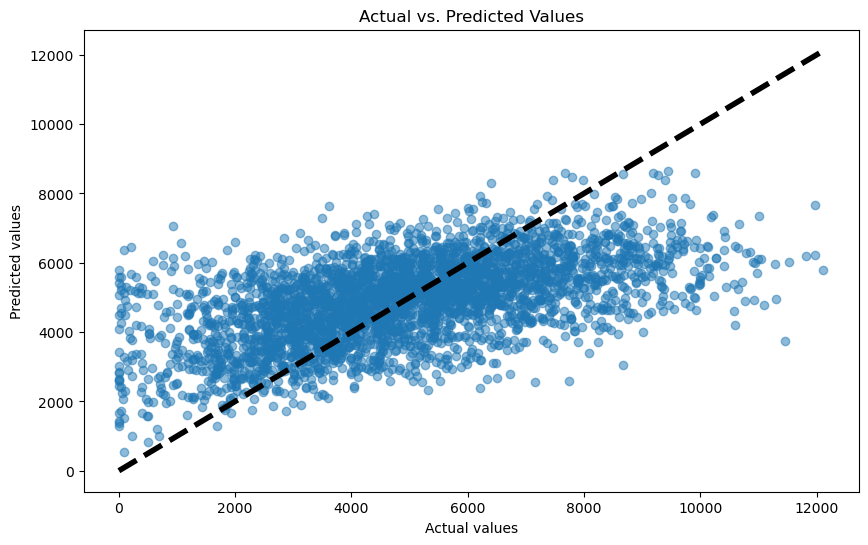

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs. Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.show()


In [ ]:
# cleaned_file_path = 'C:\\Users\\gagno\\OneDrive\\Documents\\Capstone\\Cleaned_GenericWellData.xlsx'
# data.to_excel(cleaned_file_path, index=False)
